**2.1.1: Setup**

Importing various required modules and the MNIST dataset. Initializing randomizer.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
# Static random seed
np.random.seed(89)

# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
# Also experienced other trouble when having the PIL image
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension

# Standard MNIST dataset (not binarized)
mnist_train_data = MNIST("./temp/", transform=pil2tensor, download=True, train=True)
mnist_test_data = MNIST("./temp/", transform=pil2tensor, download=True, train=False)

**2.1.2: Plot 8x8 random samples**

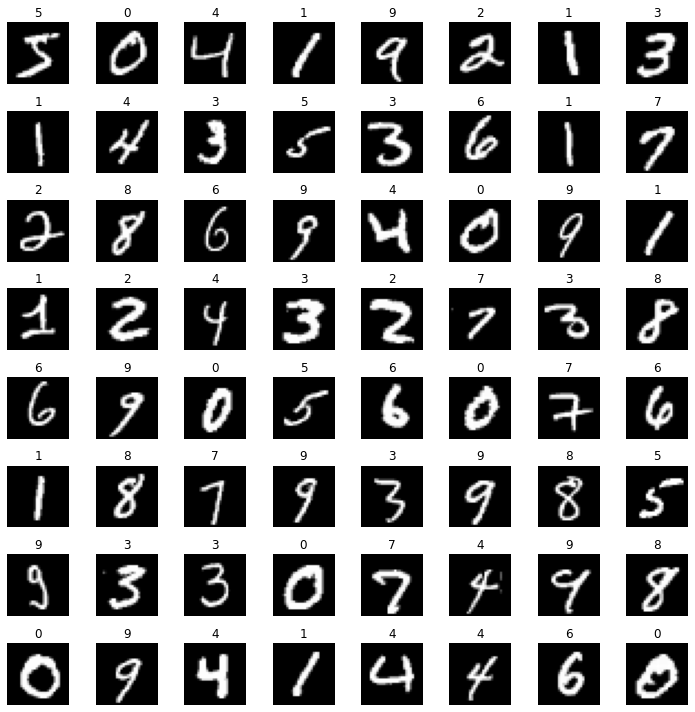

In [2]:
from torch.utils.data import DataLoader

mnist_train_loader = DataLoader(mnist_train_data, batch_size = 64)
images, labels = next(iter(mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.1.3: Implement dynamic binarization**

Sampling binarized pixels using intensity as probability.

In [3]:
# Setup Bernoulli statistical sampling conversion from grey-scale to binary
from torchvision import transforms

# AXBR: bit wierd, I thought we would need to normalize the image to [0,1] like this:
#      transforms.Lambda(lambda x: torch.bernoulli(x.double()/255))]))
# because the MNIST image uses unsigned 8-bit, and thus have range 0-255. Does PyTorch datasets normalize when using __getitem__ ?
# When using 'data[idx]' method the data comes out raw (0-255) without the transform being performed.
# Seems the transform is only attached to the dataset, and first invoked when doing '__getitem__'.
binarized_mnist_train_data = MNIST("./temp/",
                                   download=True,
                                   train=True,
                                   transform=transforms.Compose([pil2tensor,
                                                                 transforms.Lambda(lambda x: torch.bernoulli(x))]))
binarized_mnist_test_data = MNIST("./temp/",
                                  download=True,
                                  train=False,
                                  transform=transforms.Compose([pil2tensor,
                                                                transforms.Lambda(lambda x: torch.bernoulli(x))]))

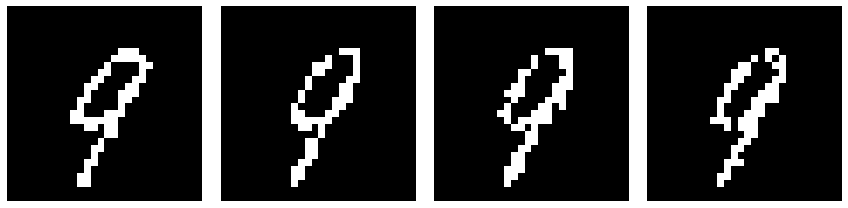

In [4]:
# Plot same image a couple of times to verify we are doing statistical sampling every time the image is drawn
fig, axs = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)
for ax in axs.flat:
    sample = binarized_mnist_train_data.__getitem__(22)[0]
    assert torch.max(sample) == 1.0
    assert torch.min(sample) == 0.0
    ax.imshow(sample, cmap='gray')
    ax.axis('off')
plt.tight_layout()

**2.1.4: Plot binarized MNIST samples**

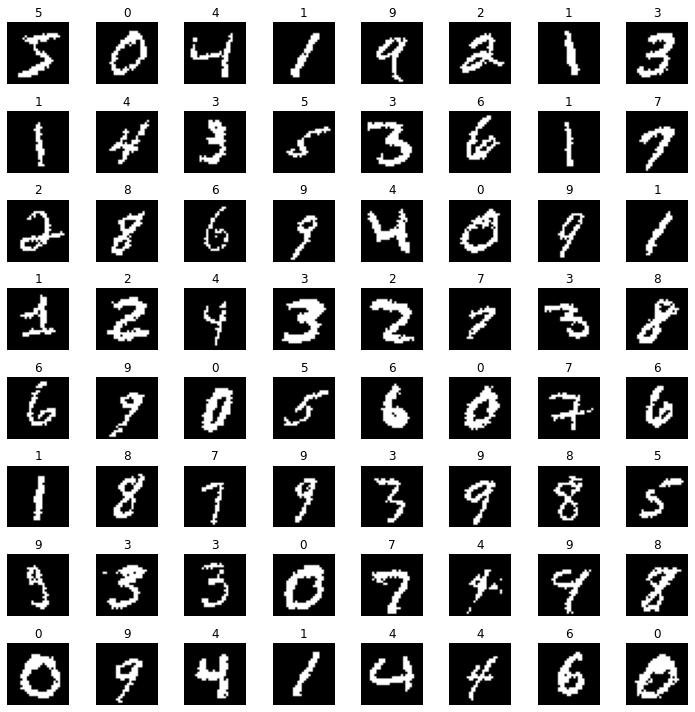

In [5]:
from torch.utils.data import DataLoader

binarized_mnist_train_loader = DataLoader(binarized_mnist_train_data, batch_size = 64)
images, labels = next(iter(binarized_mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.2.1.1: VAE implementation**

In [6]:
# Implement reparameterized diagonal gaussian
from torch.distributions import Distribution

class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

In [7]:
# Return sum of values in all dimenensions, except the first one, which is assumed to be batch
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [8]:
from typing import Dict, Any

from torch.distributions import Bernoulli

# Define hidden layer topology - list of sizes of hidden layers
encoder_dimensions = [512, 256, 128]
decoder_dimensions = [128, 256, 512]
apply_per_layer_batchnorm = False

# Implement VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #self.prior_params = torch.zeros(torch.Size([1, 2*latent_features]))
        
        # Dynamically constructing the encoder network
        encoder_constructor = []
        encoder_constructor.append(nn.Linear(in_features=self.observation_features, out_features=encoder_dimensions[0]))
        encoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[0]))
        for i in range(len(encoder_dimensions)-1):
            encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[i], out_features=encoder_dimensions[i+1]))
            encoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[i+1]))
        encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[-1], out_features=2*self.latent_features))
        self.encoder = nn.Sequential(*encoder_constructor)

        # Dynamically constructing the decoder network
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features=self.latent_features, out_features=decoder_dimensions[0]))
        decoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[0]))
        for i in range(len(decoder_dimensions)-1):
            decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[i], out_features=decoder_dimensions[i+1]))
            decoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[i+1]))
        decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[-1], out_features=self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample()
        x = x.view(x.size(0), -1)
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # flatten the input
        x = x.view(x.size(0), -1)
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.encode(x)
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        # define the observation model p(x|z) = B(x | g(z))
        px = self.decode(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

In [9]:
# Instantiate a VAE
testVAE = VariationalAutoEncoder(sample.flatten().shape, 5)
print(testVAE.encoder)
print(testVAE.decoder)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=5, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
)


**2.2.1.2: Print samples from untrained VAE**

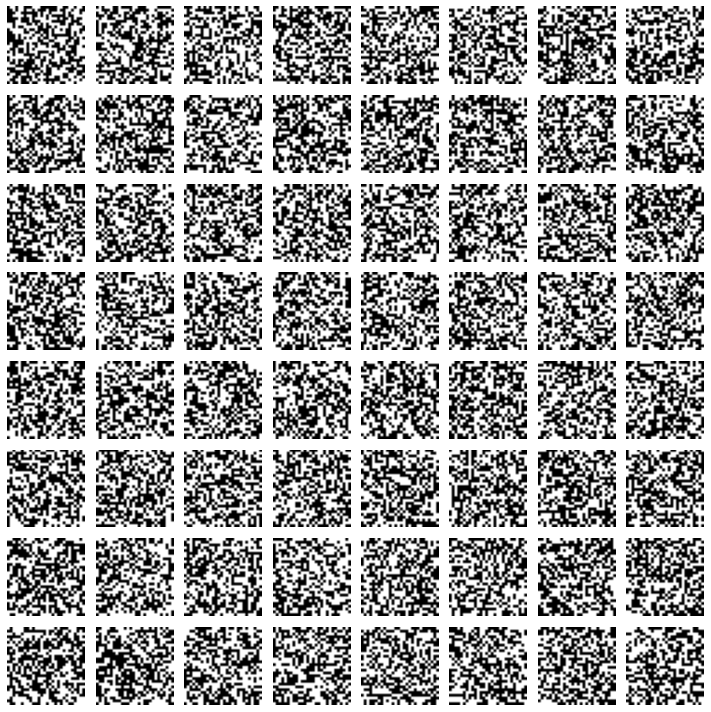

In [10]:
# Method 1: Decoding sample from prior
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

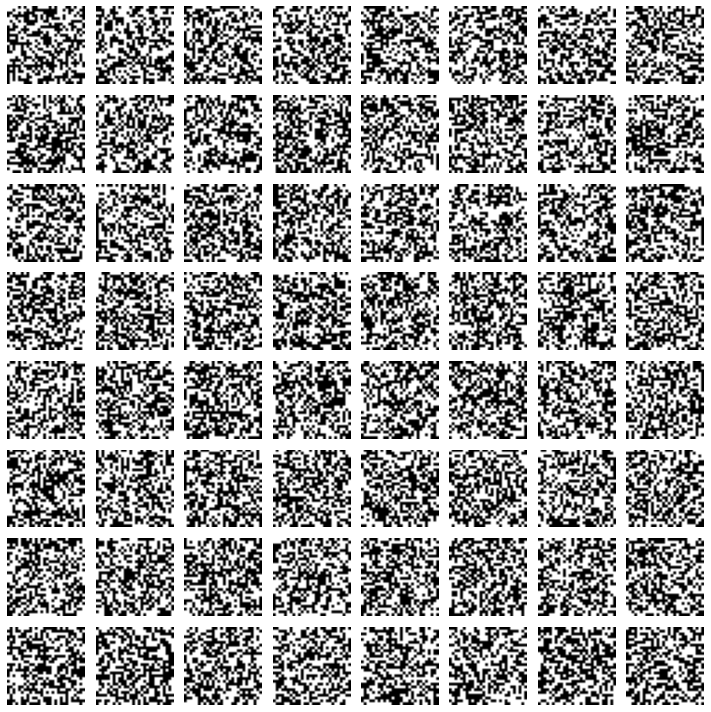

In [11]:
# Method 2: Reconstruction of input from binarized MNIST
a = random.choices(binarized_mnist_train_data,k=64)
b = [x[0] for x in a]
img = torch.stack(b)
sampled_decode_content = testVAE(img)['px'].sample().view(-1,28,28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

**2.2.1.3: Compute ELBO of 64 samples**

In [12]:
samples = np.zeros(shape=(64, 784))
labels = np.zeros(shape=(64, 1))
for i in range(64):
    sample = random.choice(binarized_mnist_train_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]

prior = testVAE.prior(64)
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

print("ELBO: ", elbo)

ELBO:  tensor([-544.4968, -545.3740, -544.9917, -544.5782, -544.4891, -543.7833,
        -543.9655, -544.7571, -544.7515, -543.6780, -544.0482, -544.3519,
        -545.1326, -545.7284, -544.6069, -544.3371, -545.0292, -544.4658,
        -544.3409, -543.9904, -543.9854, -543.9454, -544.5156, -544.1238,
        -544.7529, -543.8929, -544.0154, -545.0735, -544.1069, -544.2358,
        -544.5121, -544.5087, -544.5946, -544.9629, -543.8868, -545.7087,
        -544.6585, -544.9090, -544.0701, -544.1245, -545.1832, -545.1852,
        -544.2183, -544.2053, -544.9603, -543.6835, -543.8076, -545.5562,
        -544.9175, -544.7800, -544.5588, -544.4039, -544.0246, -545.3515,
        -544.5721, -545.3657, -545.3594, -544.5542, -543.4811, -544.8015,
        -544.3776, -545.3632, -544.9001, -544.0181], grad_fn=<SubBackward0>)


**2.2.2.1 and 2.2.2.2: Implementing train and test methods in training helper class**

In [13]:
from torch import optim

class VAE_Trainer:
    def __init__(self, network: VariationalAutoEncoder, train: DataLoader, test: DataLoader):
        self.VAE = network
        self.train_data = train
        self.test_data = test
        if torch.cuda.is_available():
            self.device = "cuda:0"
            network.cuda()
        else:
            self.device = "cpu"
            network.cpu()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.VAE.train()
        for images, labels in self.train_data:
            images = images.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.VAE(images)
            loss = -self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
    
    def test(self):
        self.VAE.eval()
        losses = []
        i = 0
        for images, labels in self.test_data:
            images = images.to(self.device)
            outputs = self.VAE(images)
            elbos = self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).cpu().detach().numpy()
            losses = np.append(losses, elbos)
        loss = -np.mean(losses)
        print("Loss: ", loss)

**2.2.2.3: Training the network**

**ToDo:** Implement state saving

In [14]:
binarized_mnist_test_loader = DataLoader(binarized_mnist_test_data, batch_size = 64)

trainer = VAE_Trainer(testVAE, binarized_mnist_train_loader, binarized_mnist_test_loader)
epochs = 200

for i in range(epochs):
    print("Training epoch ", i)
    trainer.train()
    print("Testing epoch ", i)
    trainer.test()

Training epoch  0
Testing epoch  0
Loss:  160.92956235542297
Training epoch  1
Testing epoch  1
Loss:  145.6935657093048
Training epoch  2
Testing epoch  2
Loss:  139.5135972240448
Training epoch  3
Testing epoch  3
Loss:  136.50629659423828
Training epoch  4
Testing epoch  4
Loss:  131.43386640319824
Training epoch  5
Testing epoch  5
Loss:  129.75353998126982
Training epoch  6
Testing epoch  6
Loss:  128.32416782722473
Training epoch  7
Testing epoch  7
Loss:  125.13500771541595
Training epoch  8
Testing epoch  8
Loss:  123.73757730083466
Training epoch  9
Testing epoch  9
Loss:  122.92818613700867
Training epoch  10
Testing epoch  10
Loss:  122.50110432949066
Training epoch  11
Testing epoch  11
Loss:  119.35535424118042
Training epoch  12
Testing epoch  12
Loss:  120.28892323436737
Training epoch  13
Testing epoch  13
Loss:  118.70210296173096
Training epoch  14
Testing epoch  14
Loss:  118.22167756328582
Training epoch  15
Testing epoch  15
Loss:  117.59266238079071
Training epoch

Testing epoch  130
Loss:  113.13025547180176
Training epoch  131
Testing epoch  131
Loss:  113.35815363292694
Training epoch  132
Testing epoch  132
Loss:  113.35033264160157
Training epoch  133
Testing epoch  133
Loss:  113.49677812576294
Training epoch  134
Testing epoch  134
Loss:  113.58190363082886
Training epoch  135
Testing epoch  135
Loss:  113.76433427772523
Training epoch  136
Testing epoch  136
Loss:  112.97976367664337
Training epoch  137
Testing epoch  137
Loss:  113.27236167736054
Training epoch  138
Testing epoch  138
Loss:  112.99833080692291
Training epoch  139
Testing epoch  139
Loss:  113.83052292861939
Training epoch  140
Testing epoch  140
Loss:  112.47143652420044
Training epoch  141
Testing epoch  141
Loss:  113.35459024047852
Training epoch  142
Testing epoch  142
Loss:  113.09631373271942
Training epoch  143
Testing epoch  143
Loss:  113.56509191379547
Training epoch  144
Testing epoch  144
Loss:  113.06499040317536
Training epoch  145
Testing epoch  145
Loss: 

**2.2.2.4: Generating samples from trained model**

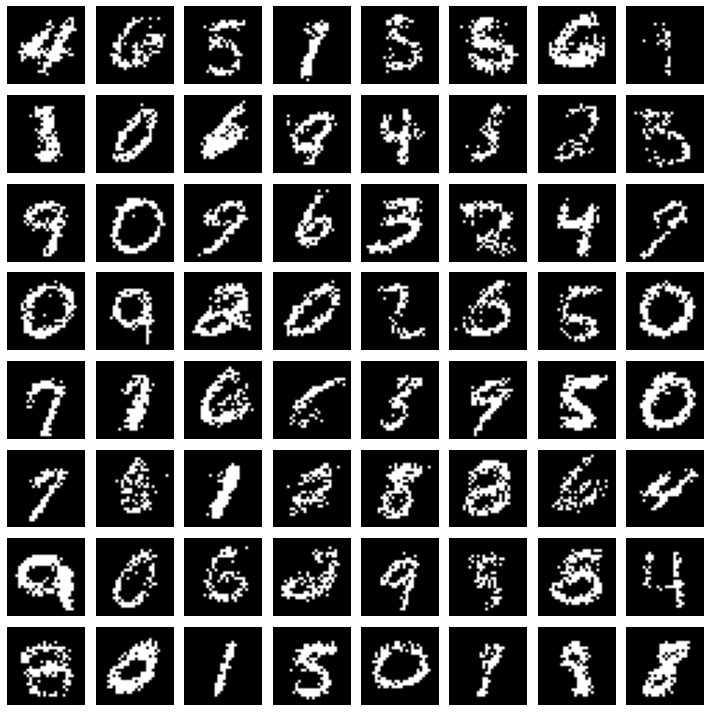

In [15]:
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

In [16]:
samples = np.zeros(shape=(64, 784))
labels = np.zeros(shape=(64, 1))
for i in range(64):
    sample = random.choice(binarized_mnist_train_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]

prior = testVAE.prior(64)
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

print("ELBO: ", elbo)

ELBO:  tensor([-164.6891, -122.8347, -147.9714,  -80.6214,  -82.5334, -123.1639,
        -136.2610,  -44.9284, -175.8901, -140.8690,  -95.1151,  -96.5007,
         -63.2208,  -86.5126, -124.2348, -112.7758, -107.3778, -108.2808,
        -102.1054,  -44.0725, -121.3834, -234.8078, -108.4888,  -84.0212,
         -76.1279, -144.2902, -103.6039,  -79.9419, -180.5442, -120.4536,
        -126.6075, -119.4990, -149.2357, -143.3219, -110.8841, -127.6886,
        -105.5982,  -61.2285, -103.8750,  -96.1424, -109.7559, -128.7578,
         -98.9275, -210.0275, -167.3369, -172.6354, -137.4093, -128.1480,
        -113.5652,  -72.2840, -141.1476, -134.1576, -103.1541, -124.4839,
        -137.8241, -102.4748, -143.6277, -113.4727, -148.9762, -104.7446,
         -92.9537, -124.9886, -109.5741, -127.6057], grad_fn=<SubBackward0>)


**2.3.1: Extracting 10 samples per class for classification training**

**ToDo:** Consider more elegant solution for classification_sampler

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
from functools import reduce

def classification_sampler(labels):
    indices = []
    for i in range(10):
        (tmp_indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i]))
        indices.append(random.choices(tmp_indices, k=10))
    indices = torch.Tensor(indices)
    indices = indices.view(1, -1).squeeze().int()
    return SubsetRandomSampler(indices)
    
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=25,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))

for images, labels in classification_loader:
    print(labels)

tensor([4, 5, 9, 3, 6, 3, 0, 4, 0, 4, 8, 0, 5, 9, 0, 7, 5, 2, 2, 4, 0, 8, 3, 6,
        7])
tensor([5, 8, 0, 7, 0, 1, 1, 3, 9, 2, 9, 5, 9, 5, 3, 1, 8, 1, 6, 6, 5, 9, 2, 7,
        9])
tensor([2, 1, 3, 8, 4, 5, 8, 2, 6, 2, 0, 9, 1, 8, 2, 1, 3, 8, 4, 7, 6, 3, 4, 0,
        6])
tensor([0, 7, 6, 2, 7, 6, 8, 2, 6, 1, 4, 4, 1, 1, 5, 8, 7, 3, 9, 7, 3, 5, 9, 4,
        7])


C:\Users\axbr\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


**2.3.2: Training classifier on latent representation**

In [18]:
# Define a classification model

class LatentClassifier(nn.Module):
    def __init__(self, latent_features:int) -> None:
        super(LatentClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(latent_features*2),
                                   nn.Linear(in_features=latent_features*2, out_features=10), 
                                   nn.ReLU())
        
    def forward(self, x) -> Tensor:
        x = self.model(x)
        return x

In [19]:
testVAE.eval()

testLC = LatentClassifier(5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(testLC.parameters(), lr=0.001, momentum=0.9)

epoch = 200
for i in range(epoch):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    testLC.eval()
    tests = 0
    correct = 0
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        for i in range(preds.shape[0]):
            tests += 1
            if labels[i] == preds[i]:
                correct += 1
    print("Accuracy: ", correct / tests)

Accuracy:  0.08
Accuracy:  0.09
Accuracy:  0.08
Accuracy:  0.09
Accuracy:  0.12
Accuracy:  0.13
Accuracy:  0.16
Accuracy:  0.14
Accuracy:  0.14
Accuracy:  0.15
Accuracy:  0.18
Accuracy:  0.19
Accuracy:  0.18
Accuracy:  0.2
Accuracy:  0.22
Accuracy:  0.21
Accuracy:  0.25
Accuracy:  0.25
Accuracy:  0.25
Accuracy:  0.27
Accuracy:  0.25
Accuracy:  0.28
Accuracy:  0.29
Accuracy:  0.29
Accuracy:  0.28
Accuracy:  0.32
Accuracy:  0.31
Accuracy:  0.3
Accuracy:  0.3
Accuracy:  0.31
Accuracy:  0.3
Accuracy:  0.31
Accuracy:  0.33
Accuracy:  0.31
Accuracy:  0.3
Accuracy:  0.32
Accuracy:  0.33
Accuracy:  0.33
Accuracy:  0.32
Accuracy:  0.36
Accuracy:  0.34
Accuracy:  0.35
Accuracy:  0.34
Accuracy:  0.35
Accuracy:  0.38
Accuracy:  0.37
Accuracy:  0.36
Accuracy:  0.37
Accuracy:  0.36
Accuracy:  0.37
Accuracy:  0.37
Accuracy:  0.37
Accuracy:  0.38
Accuracy:  0.4
Accuracy:  0.39
Accuracy:  0.39
Accuracy:  0.39
Accuracy:  0.4
Accuracy:  0.41
Accuracy:  0.39
Accuracy:  0.42
Accuracy:  0.4
Accuracy:  0.44


**2.3.3: Classifying MNIST using simple FFNN**

In [20]:
# Define a classification model

class SimpleClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(input_shape),
                                   nn.Linear(in_features=input_shape, out_features=512), 
                                   nn.ReLU(),
                                   nn.Linear(in_features=512, out_features=256),
                                   nn.ReLU(),
                                   nn.Linear(in_features=256, out_features=10),
                                   nn.ReLU())
        
    def forward(self, x) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [21]:
testSC = SimpleClassifier(784)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(testSC.parameters(), lr=0.001, momentum=0.9)

epoch = 200
for i in range(epoch):
    # Training
    testSC.train()
    for images, labels in classification_loader:
        optimizer.zero_grad()
        classifications = testSC(images)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    testSC.eval()
    tests = 0
    correct = 0
    for images, labels in classification_loader:
        classifications = testSC(images)
        preds = torch.max(classifications, 1)[1]
        for i in range(preds.shape[0]):
            tests += 1
            if labels[i] == preds[i]:
                correct += 1
    print("Accuracy: ", correct / tests)

Accuracy:  0.07
Accuracy:  0.08
Accuracy:  0.09
Accuracy:  0.14
Accuracy:  0.15
Accuracy:  0.2
Accuracy:  0.25
Accuracy:  0.32
Accuracy:  0.3
Accuracy:  0.37
Accuracy:  0.34
Accuracy:  0.32
Accuracy:  0.32
Accuracy:  0.36
Accuracy:  0.36
Accuracy:  0.34
Accuracy:  0.35
Accuracy:  0.38
Accuracy:  0.39
Accuracy:  0.41
Accuracy:  0.42
Accuracy:  0.41
Accuracy:  0.41
Accuracy:  0.39
Accuracy:  0.41
Accuracy:  0.39
Accuracy:  0.43
Accuracy:  0.43
Accuracy:  0.43
Accuracy:  0.45
Accuracy:  0.44
Accuracy:  0.48
Accuracy:  0.49
Accuracy:  0.47
Accuracy:  0.48
Accuracy:  0.48
Accuracy:  0.48
Accuracy:  0.51
Accuracy:  0.52
Accuracy:  0.49
Accuracy:  0.5
Accuracy:  0.49
Accuracy:  0.46
Accuracy:  0.52
Accuracy:  0.5
Accuracy:  0.52
Accuracy:  0.51
Accuracy:  0.53
Accuracy:  0.59
Accuracy:  0.55
Accuracy:  0.54
Accuracy:  0.55
Accuracy:  0.57
Accuracy:  0.56
Accuracy:  0.55
Accuracy:  0.58
Accuracy:  0.59
Accuracy:  0.61
Accuracy:  0.61
Accuracy:  0.6
Accuracy:  0.61
Accuracy:  0.6
Accuracy:  0.6